# Clustering Climate Data

In [46]:
from sentence_transformers import SentenceTransformer
import numpy as np
import umap
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from transformers import AutoModel, AutoTokenizer
import torch
import hdbscan
import pandas as pd
from sklearn.decomposition import PCA
import pickle

## Data

In [47]:
topics = ['energy mix', 'carbon tax', 'energy subsidy', 'green energy', 'carbon capture', 'private renewable energy']

In [48]:
# If the file is in the same directory as the script
summaries = pd.read_excel("summaries.xlsx", engine="openpyxl")

In [49]:
summaries = summaries.drop(columns=['who'])

In [50]:
summaries

,country,energy mix,carbon tax,energy subsidy,green energy,carbon capture,private renewable energy
0,UK,The UK's energy mix policy focuses on transiti...,The UK has not implemented or proposed a carbo...,The United Kingdom has implemented several ini...,The UK's green energy transition is multifacet...,The UK is actively exploring carbon capture te...,The UK's reliance on private investment for cl...
1,South Korea,South Korea's energy mix policy reflects a str...,South Korea has implemented a carbon tax as pa...,South Korea's energy subsidy policy heavily su...,South Korea's green energy policy is centered ...,South Korea has committed to achieving carbon ...,South Korea's renewable energy policy is cente...
2,USA,The U.S. energy mix is poised for significant ...,The United States currently lacks a nationwide...,The United States provides subsidies for vario...,The United States is transitioning to net-zero...,The United States has considered carbon captur...,The United States is heavily reliant on privat...
3,China,China is advancing its renewable energy strate...,China has not yet implemented a national carbo...,China implements a range of energy subsidy pol...,China's transition to a net-zero energy system...,China is actively working towards reducing its...,China's renewable energy policies aim to achie...
4,Canada,The Renewable Energy Future Plan introduced by...,Canada has indeed implemented a carbon pricing...,"Based on government initiatives, electric vehi...",Canada is transitioning toward a net-zero emis...,Canada has actively implemented carbon capture...,Canada is increasingly relying on private inve...
5,Mexico,Mexico's energy mix is transitioning toward a ...,Mexico has implemented a national carbon tax a...,Mexico has implemented significant subsidies p...,Mexico's green energy strategy is multifaceted...,Mexico has been exploring carbon capture techn...,Mexico’s private renewable energy policy empha...
6,Ireland,Ireland's energy mix policy emphasizes a stron...,Ireland has successfully implemented a carbon ...,1. Focus on Renewable Energy:\n - Renewable ...,Ireland is transitioning toward its net-zero c...,"Based on the analysis of both passages, Irelan...",Ireland's climate strategy heavily relies on p...
7,Japan,Japan's energy mix policy is focused on transi...,"Japan's carbon tax policy, known as the ""Tax f...",Japan's energy subsidy policies are centered a...,Japan is advancing its transition to net-zero ...,Japan is actively advancing its carbon capture...,Japan's reliance on private investment to achi...
8,Turkey,Turkey has a comprehensive plan to shift its e...,Turkey has not yet implemented a carbon tax. T...,Turkey's energy subsidy policy places a signif...,Turkey's green energy strategy for achieving n...,Turkey has not implemented significant carbon ...,Turkey is actively transitioning to achieve it...
9,Indonesia,Indonesia is transitioning its energy mix towa...,Indonesia has been actively considering implem...,Indonesia provides significant subsidies prima...,Indonesia is committed to achieving net-zero e...,Indonesia is actively advancing its climate ch...,Indonesia is heavily reliant on foreign invest...


## Get embeddings

In [51]:
# Load small embedding model
model_name = "sentence-transformers/all-mpnet-base-v2"  # Use a TinyLlama model, sentence-transformers/all-MiniLM-L6-v2, BAAI/bge-small-en, sentence-transformers/all-mpnet-base-v2
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [53]:
# Convert text to embeddings
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [54]:
# loop through all the topics to get the embeddings 
# Select the columns for the content (excluding 'country' and citation columns)
content_columns = summaries.columns[1:7]  # This selects the columns from 'energy mix' to 'private renewable energy'

# List to hold the text summaries for each topic
text_summaries = []

# Dictionary to store the embeddings for each topic
embeddings_dict = {}

# Loop through each content column and extract the information column by column
for column in content_columns:
    topic_summaries = []
    for index, row in summaries.iterrows():
        country = row['country']  # Get the country for this row
        content = row[column]  # Get the content of the current column
        topic_summaries.append(content)  # Collect content for each country in the current topic
    embeddings = np.array([get_embedding(text) for text in topic_summaries])
    # After processing each topic, save the embeddings for that topic
    embeddings_dict[column] = embeddings  # Store the embeddings for this topic
    # text_summaries.append(topic_summaries)  

In [55]:
# Extract all unique country names
all_countries = summaries.iloc[:, 0] 

## UMAP

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


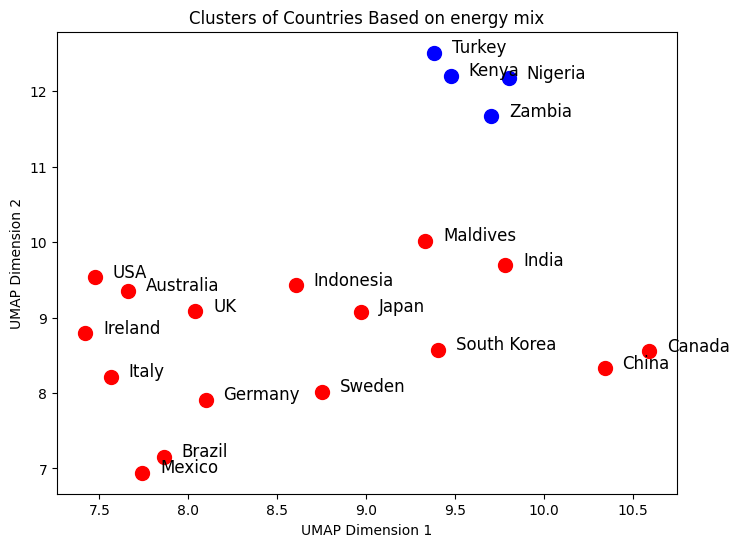

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


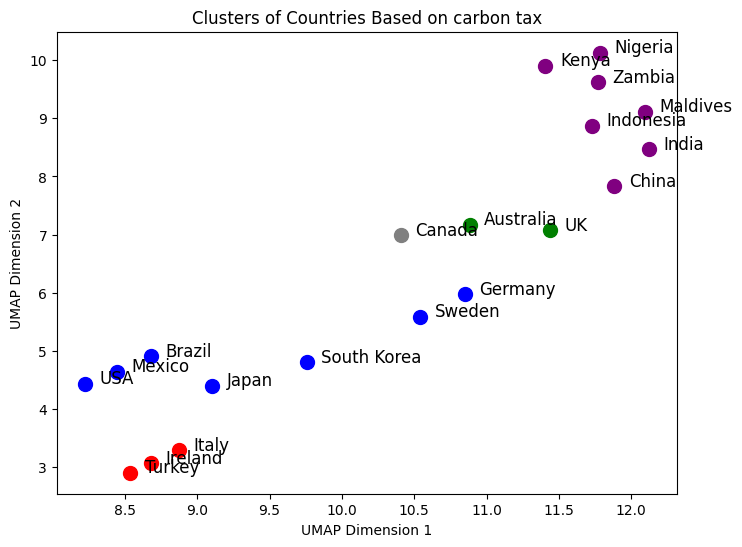

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


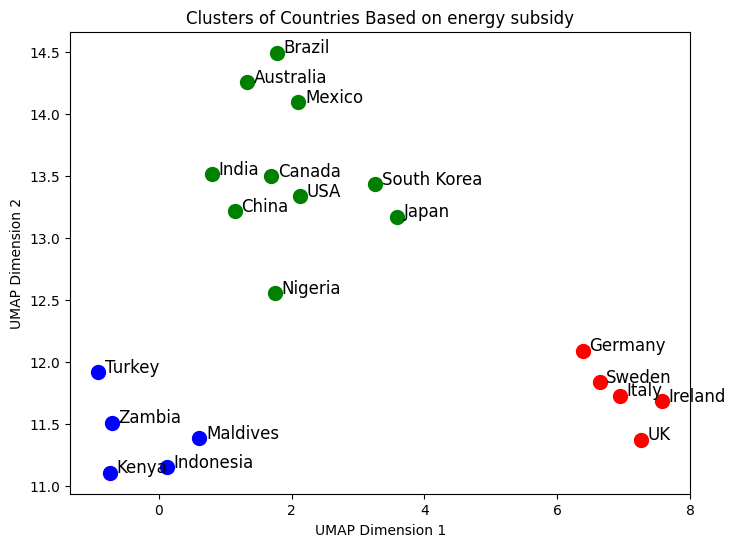

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


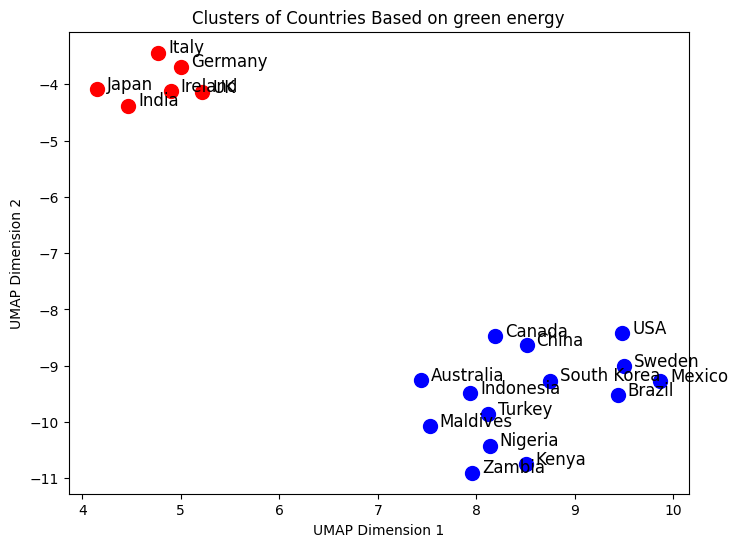

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


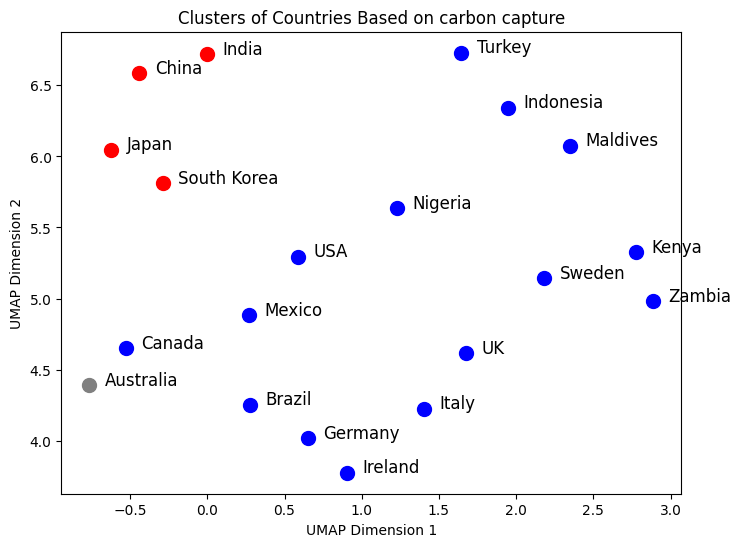

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


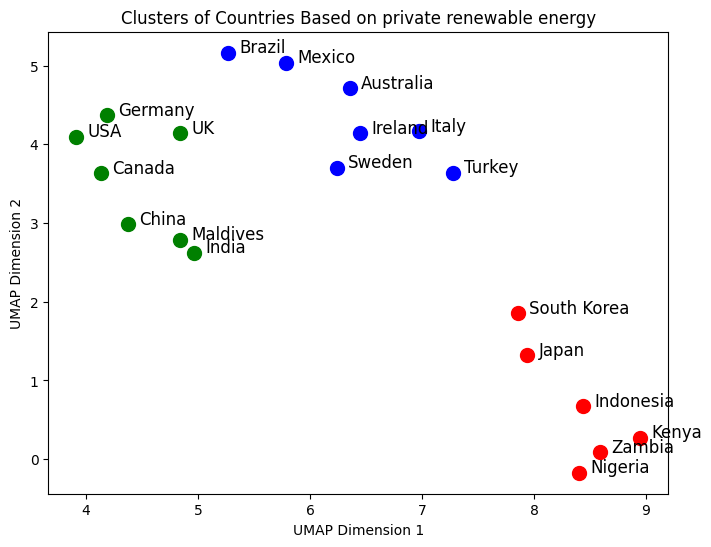

In [56]:
# Initialize an empty DataFrame
df_results = pd.DataFrame({'country': all_countries})

for topic, embeddings in embeddings_dict.items():
    umap_reducer = umap.UMAP(n_neighbors=3, n_components=2, metric='cosine')
    reduced_embeddings = umap_reducer.fit_transform(embeddings)

    # Convert to DataFrame
    topic_df = pd.DataFrame(reduced_embeddings, columns=[f'x_{topic}', f'y_{topic}'])

    # Add topic embeddings to main DataFrame
    df_results = pd.concat([df_results, topic_df], axis=1)

    # Cluster using HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
    clusters = clusterer.fit_predict(reduced_embeddings)

    # Assign colors to clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    cluster_colors = [colors[label] if label != -1 else 'gray' for label in clusters]

    # Plot results
    plt.figure(figsize=(8,6))
    for i in range(len(all_countries)):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=cluster_colors[i], s=100)
        plt.text(reduced_embeddings[i, 0]+0.1, reduced_embeddings[i, 1], all_countries[i], fontsize=12)

    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.title(f"Clusters of Countries Based on {topic}")
    plt.show()


## Save coordinates

In [57]:
df_results

,country,x_energy mix,y_energy mix,x_carbon tax,y_carbon tax,x_energy subsidy,y_energy subsidy,x_green energy,y_green energy,x_carbon capture,y_carbon capture,x_private renewable energy,y_private renewable energy
0,UK,8.039818,9.087875,11.435826,7.075691,7.256609,11.372369,5.218941,-4.145793,1.675453,4.613261,4.839309,4.141623
1,South Korea,9.405909,8.575678,9.758140,4.808353,3.254990,13.429236,8.749681,-9.265448,-0.289272,5.812930,7.858284,1.851971
2,USA,7.473545,9.532760,8.224910,4.434617,2.125465,13.335693,9.482842,-8.419647,0.588347,5.293510,3.914209,4.098482
3,China,10.342660,8.331927,11.882980,7.835476,1.144142,13.212039,8.509377,-8.636802,-0.441129,6.584045,4.374965,2.987695
4,Canada,10.590259,8.556239,10.408725,6.989206,1.696752,13.497490,8.191014,-8.470955,-0.526257,4.648440,4.133698,3.632490
5,Mexico,7.740652,6.943626,8.446375,4.640361,2.101433,14.094200,9.868366,-9.273999,0.271139,4.883852,5.788758,5.035656
6,Ireland,7.420073,8.792917,8.679283,3.068044,7.577205,11.683401,4.898712,-4.126851,0.904091,3.774425,6.448706,4.138465
7,Japan,8.973293,9.080612,9.102868,4.396276,3.585032,13.169108,4.148420,-4.086226,-0.623039,6.048096,7.941621,1.323616
8,Turkey,9.381042,12.511633,8.536739,2.902031,-0.910480,11.918776,8.119176,-9.858964,1.646109,6.729465,7.279041,3.640928
9,Indonesia,8.605206,9.427231,11.730692,8.874081,0.125775,11.151402,7.936465,-9.487873,1.946771,6.341785,8.437993,0.673377


In [60]:
# add summaries and citations 
merged_df = pd.merge(df_results, summaries, on="country", how="inner")

In [61]:
merged_df

,country,x_energy mix,y_energy mix,x_carbon tax,y_carbon tax,x_energy subsidy,y_energy subsidy,x_green energy,y_green energy,x_carbon capture,y_carbon capture,x_private renewable energy,y_private renewable energy,energy mix,carbon tax,energy subsidy,green energy,carbon capture,private renewable energy
0,UK,8.039818,9.087875,11.435826,7.075691,7.256609,11.372369,5.218941,-4.145793,1.675453,4.613261,4.839309,4.141623,The UK's energy mix policy focuses on transiti...,The UK has not implemented or proposed a carbo...,The United Kingdom has implemented several ini...,The UK's green energy transition is multifacet...,The UK is actively exploring carbon capture te...,The UK's reliance on private investment for cl...
1,South Korea,9.405909,8.575678,9.758140,4.808353,3.254990,13.429236,8.749681,-9.265448,-0.289272,5.812930,7.858284,1.851971,South Korea's energy mix policy reflects a str...,South Korea has implemented a carbon tax as pa...,South Korea's energy subsidy policy heavily su...,South Korea's green energy policy is centered ...,South Korea has committed to achieving carbon ...,South Korea's renewable energy policy is cente...
2,USA,7.473545,9.532760,8.224910,4.434617,2.125465,13.335693,9.482842,-8.419647,0.588347,5.293510,3.914209,4.098482,The U.S. energy mix is poised for significant ...,The United States currently lacks a nationwide...,The United States provides subsidies for vario...,The United States is transitioning to net-zero...,The United States has considered carbon captur...,The United States is heavily reliant on privat...
3,China,10.342660,8.331927,11.882980,7.835476,1.144142,13.212039,8.509377,-8.636802,-0.441129,6.584045,4.374965,2.987695,China is advancing its renewable energy strate...,China has not yet implemented a national carbo...,China implements a range of energy subsidy pol...,China's transition to a net-zero energy system...,China is actively working towards reducing its...,China's renewable energy policies aim to achie...
4,Canada,10.590259,8.556239,10.408725,6.989206,1.696752,13.497490,8.191014,-8.470955,-0.526257,4.648440,4.133698,3.632490,The Renewable Energy Future Plan introduced by...,Canada has indeed implemented a carbon pricing...,"Based on government initiatives, electric vehi...",Canada is transitioning toward a net-zero emis...,Canada has actively implemented carbon capture...,Canada is increasingly relying on private inve...
5,Mexico,7.740652,6.943626,8.446375,4.640361,2.101433,14.094200,9.868366,-9.273999,0.271139,4.883852,5.788758,5.035656,Mexico's energy mix is transitioning toward a ...,Mexico has implemented a national carbon tax a...,Mexico has implemented significant subsidies p...,Mexico's green energy strategy is multifaceted...,Mexico has been exploring carbon capture techn...,Mexico’s private renewable energy policy empha...
6,Ireland,7.420073,8.792917,8.679283,3.068044,7.577205,11.683401,4.898712,-4.126851,0.904091,3.774425,6.448706,4.138465,Ireland's energy mix policy emphasizes a stron...,Ireland has successfully implemented a carbon ...,1. Focus on Renewable Energy:\n - Renewable ...,Ireland is transitioning toward its net-zero c...,"Based on the analysis of both passages, Irelan...",Ireland's climate strategy heavily relies on p...
7,Japan,8.973293,9.080612,9.102868,4.396276,3.585032,13.169108,4.148420,-4.086226,-0.623039,6.048096,7.941621,1.323616,Japan's energy mix policy is focused on transi...,"Japan's carbon tax policy, known as the ""Tax f...",Japan's energy subsidy policies are centered a...,Japan is advancing its transition to net-zero ...,Japan is actively advancing its carbon capture...,Japan's reliance on private investment to achi...
8,Turkey,9.381042,12.511633,8.536739,2.902031,-0.910480,11.918776,8.119176,-9.858964,1.646109,6.729465,7.279041,3.640928,Turkey has a comprehensive plan to shift its e...,Turkey has not yet implemented a carbon tax. T...,Turkey's energy subsidy policy places a signif...,Turkey's green energy strategy for achieving n...,Turkey has no

In [62]:
# Save DataFrame to CSV
merged_df.to_csv("country_embeddings.csv", index=False)

## PCA

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


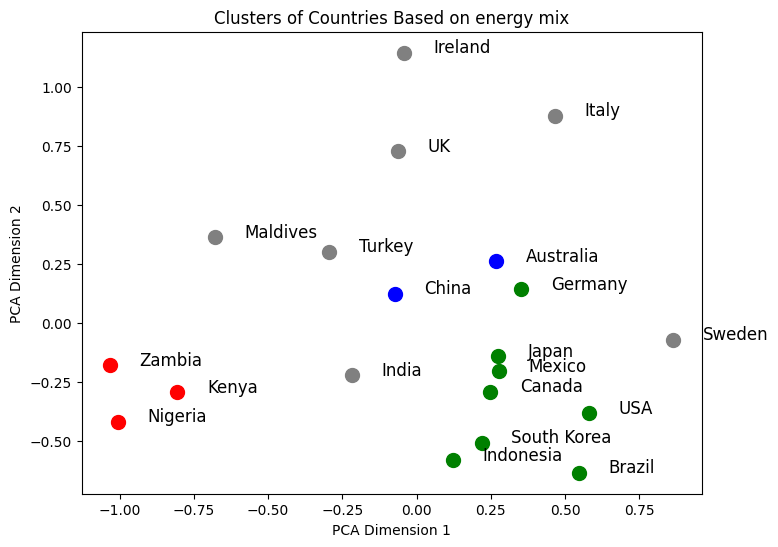

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


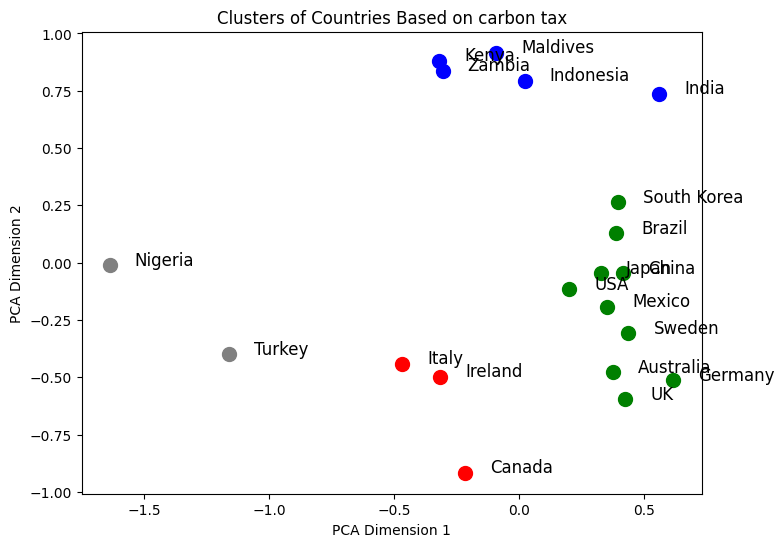

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


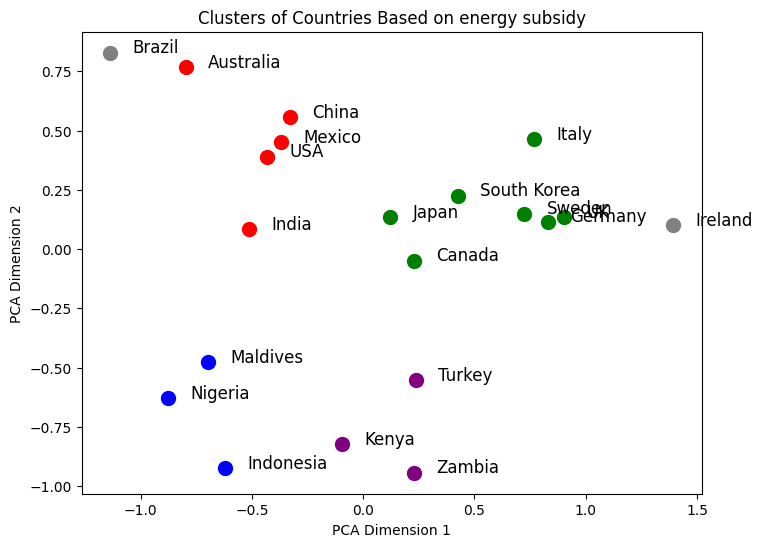

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


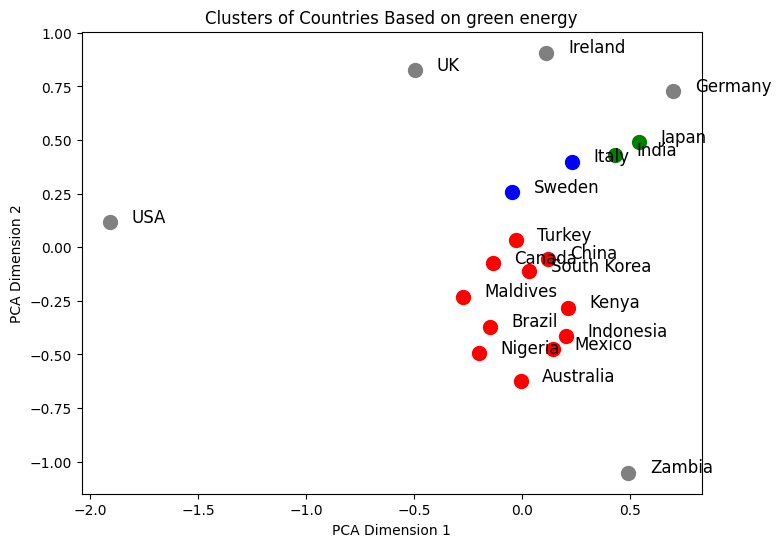

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


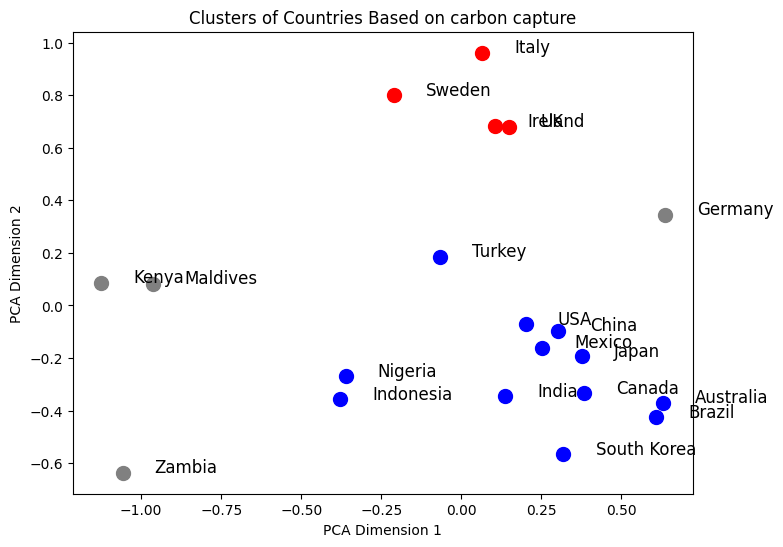

/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


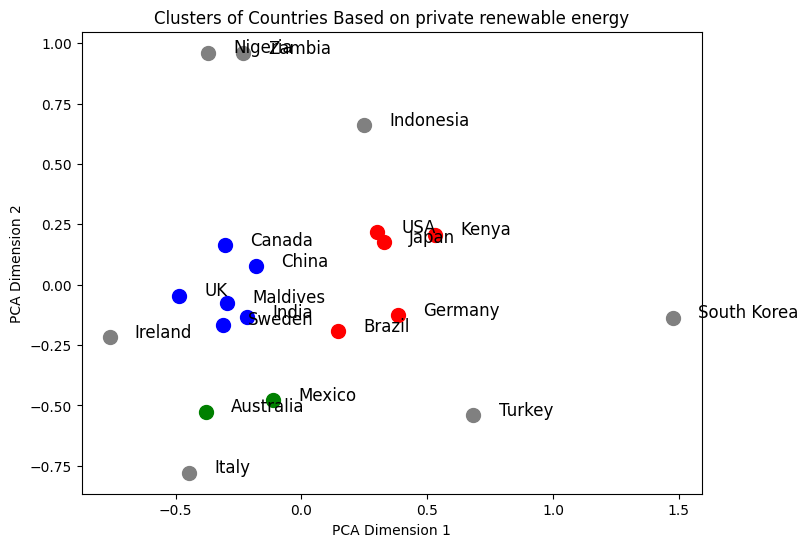

In [32]:
country_names = summaries['country'].tolist()
df_coordinates = pd.DataFrame(country_names, columns=["country"])
for topic, embeddings in embeddings_dict.items():
    # Replace UMAP with PCA
    pca_reducer = PCA(n_components=2)
    reduced_embeddings = pca_reducer.fit_transform(embeddings)

    # Cluster using HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=2, metric='euclidean')
    clusters = clusterer.fit_predict(reduced_embeddings)

    # Assign colors to clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    cluster_colors = [colors[label] if label != -1 else 'gray' for label in clusters]

    # Create separate columns for x and y coordinates for each topic
    df_coordinates[f"x_{topic}"] = reduced_embeddings[:, 0]  # First dimension
    df_coordinates[f"y_{topic}"] = reduced_embeddings[:, 1]  # Second dimension

    # Plot results
    plt.figure(figsize=(8,6))
    for i, text in enumerate(embeddings):
        plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], color=cluster_colors[i], s=100)
        plt.text(reduced_embeddings[i, 0] + 0.1, reduced_embeddings[i, 1], all_countries[i], fontsize=12)

    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    plt.title(f"Clusters of Countries Based on {topic}")
    plt.show()